In [3]:
! pip install langchain langgraph ollama langchain_community langchain_core langchain-ollama arxiv wikipedia

  Using cached arxiv-2.1.3-py3-none-any.whl (11 kB)
  Using cached wikipedia-1.4.0.tar.gz (27 kB)
  Preparing metadata (setup.py) ... done
  Using cached feedparser-6.0.11-py3-none-any.whl (81 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
  Using cached sgmllib3k-1.0.0.tar.gz (5.8 kB)
  Preparing metadata (setup.py) ... done
  Using cached soupsieve-2.6-py3-none-any.whl (36 kB)
  DEPRECATION: sgmllib3k is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for sgmllib3k ... done
  DEPRECATION: wikipedia is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce thi

In [19]:
from langchain_ollama import OllamaLLM
llm = OllamaLLM(model='phi3')

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

In [5]:
# Working with External Tools

# 1. ArxivAPIWrapper: Used to interact with any research paper.
# 2. WikipediaAPIWrapper: Used to interact with Wikipedia.

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

# Configure Arxiv and Wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [9]:
print(wiki_tool.invoke("Who is Harry Potter"))

Page: Harry Potter (character)
Summary: Harry James Potter is a fictional character in the Harry Potter series of novels by J. K. Rowling. The plot of the seven-book series chronicles seven years in the life of the orphan Harry, who, on his eleventh birthday, learns he is a wizard. He attends Hogwar


In [10]:
print(arxiv_tool.invoke("Attention is all you need"))

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with 


In [11]:
tools=[wiki_tool]

In [27]:
llm_with_tools = llm.bind(tools=tools)

### Langgraph application

In [22]:
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    messages:Annotated["list", add_messages]

graph_builder = StateGraph(State)

In [23]:
def chatbot(state:State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

In [24]:
graph_builder.add_node("chatbot", chatbot)

In [29]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_edge(START, "chatbot")

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot", 
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [30]:
graph = graph_builder.compile()

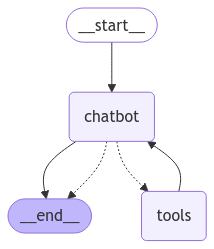

In [31]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [34]:
user_input = "What is Java?"

events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is Java?
================================ Human Message =================================

Java is a widely-used, high-level programming language designed by Sun Microsystems (which was later acquired by Oracle). It was created by James Gosling and others at Sun Microsystems in the mid-1990s. Java's primary selling point has always been its "write once, run anywhere" philosophy, thanks to the Java Virtual Machine (JVM), which allows Java programs to execute on any device that has a compatible JVM without needing recompilation.

Java is an object-oriented language with syntax and features similar to C++ and other languages like Python. It offers strong memory management, extensive libraries for graphic user interface (GUI) development, networking, database access, and more, making it a versatile choice for various types of software applications, including web and mobile app development, desktop progra